In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.models import model_from_yaml, Model
from keras.preprocessing import image
from keras.utils import plot_model
from keras.models import save_model
from keras.models import load_model
from tensorflow.keras.utils import  to_categorical
from keras.preprocessing.image import img_to_array, array_to_img


# transfer learning -- InceptionV3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# other
from pprint import pprint
from joblib import dump, load
import os
import glob

Using TensorFlow backend.


In [2]:
train = pd.read_csv("fashion-mnist_train.csv")
test = pd.read_csv("fashion-mnist_test.csv")

In [3]:
train.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


In [4]:
train['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [5]:
X_train = train.drop(columns = 'label')
y_train = train[['label']]

print(X_train.shape, y_train.shape)

(60000, 784) (60000, 1)


In [6]:
X_test = test.drop(columns = 'label')
y_test = test[['label']]

print(X_test.shape, y_test.shape)

(10000, 784) (10000, 1)


In [7]:
# convert to float because we do not want the values to just be 0 or 1 - normalize the dataset and then divide by 255

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [8]:
# for InceptionV3, we need the size to be at least 75 x 75 x 3

# first change number of channels to 3
X_train_inceptionV3 = np.dstack([X_train] * 3)
X_test_inceptionV3 = np.dstack([X_test] * 3)

print(X_train_inceptionV3.shape, X_test_inceptionV3.shape)

(60000, 784, 3) (10000, 784, 3)


In [9]:
# next reshape images to 28 x 28

X_train_inceptionV3 = X_train_inceptionV3.reshape((-1, 28, 28, 3))
X_test_inceptionV3 = X_test_inceptionV3.reshape((-1, 28, 28, 3))

print(X_train_inceptionV3.shape, X_test_inceptionV3.shape)

(60000, 28, 28, 3) (10000, 28, 28, 3)


In [10]:
# now we must resize to 75 x 75 x 3

X_train_inceptionV3 = np.asarray([img_to_array(array_to_img(img_xtr, scale=False).resize((75,75))) for img_xtr in X_train_inceptionV3])
X_test_inceptionV3 = np.asarray([img_to_array(array_to_img(img_xte, scale=False).resize((75,75))) for img_xte in X_test_inceptionV3])

print(X_train_inceptionV3.shape, X_test_inceptionV3.shape)

# yay! we have the right sizes :)

(60000, 75, 75, 3) (10000, 75, 75, 3)


In [11]:
# one hot encoding
y_train_inceptionV3 = to_categorical(y_train, num_classes = 10)
y_test_inceptionV3 = to_categorical(y_test, num_classes = 10)

print(y_train_inceptionV3.shape, y_test_inceptionV3.shape)

(60000, 10) (10000, 10)


In [12]:
# InceptionV3

# we have to preprocess the data
X_train_inceptionV3_pp = preprocess_input(X_train_inceptionV3)
X_test_inceptionV3_pp = preprocess_input(X_test_inceptionV3)

print(X_train_inceptionV3_pp.shape, X_test_inceptionV3_pp.shape)

(60000, 75, 75, 3) (10000, 75, 75, 3)


In [13]:
# load base model

incV3_base = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (75, 75, 3))
incV3_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 37, 37, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 37, 37, 32)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [14]:
# need to continue to add some layers -- see Keras documentation
x = incV3_base.output

# add Global Average Pooling as a Flatten layer (also used in Keras documentation)
x = GlobalAveragePooling2D()(x)

# add a Dense layer (fully-connected layer)
x = Dense(units = 1024, activation = 'relu')(x)

# add final Dense layer with units = # classes
predictions = Dense(units = 10, activation = 'softmax')(x)

In [15]:
# build final model

model = Model(inputs = incV3_base.input, outputs = predictions)

In [16]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers -- straight from Keras.io documentation
for layer in incV3_base.layers:
    layer.trainable = False

In [17]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [18]:
#keras.utils.plot_model(model, "Updated InceptionV3.png")

In [20]:
# fit the model
hist = model.fit(X_train_inceptionV3_pp, y_train_inceptionV3, batch_size = 32, epochs = 50)

Epoch 1/50
60000/60000 [==============================] - 414s 7ms/step - loss: 2.1081 - accuracy: 0.2265
Epoch 2/50
60000/60000 [==============================] - 417s 7ms/step - loss: 2.0432 - accuracy: 0.2525
Epoch 3/50
60000/60000 [==============================] - 417s 7ms/step - loss: 2.0145 - accuracy: 0.2633
Epoch 4/50
60000/60000 [==============================] - 417s 7ms/step - loss: 1.9979 - accuracy: 0.2718
Epoch 5/50
60000/60000 [==============================] - 417s 7ms/step - loss: 1.9864 - accuracy: 0.2764
Epoch 6/50
60000/60000 [==============================] - 417s 7ms/step - loss: 1.9755 - accuracy: 0.2809
Epoch 7/50
60000/60000 [==============================] - 417s 7ms/step - loss: 1.9750 - accuracy: 0.2808
Epoch 8/50
60000/60000 [==============================] - 417s 7ms/step - loss: 1.9622 - accuracy: 0.2819
Epoch 9/50
60000/60000 [==============================] - 417s 7ms/step - loss: 1.9612 - accuracy: 0.2877
Epoch 10/50
60000/60000 [=====================

In [21]:
# save model to disk
model.save('InceptionV3_V1_0530')

# keras.models.load_models("path")

In [24]:
# evaluate model
scores = model.evaluate(X_test_inceptionV3_pp, y_test_inceptionV3)

# prediction classes
preds = model.predict(X_test_inceptionV3_pp)

10000/10000 [==============================] - 70s 7ms/step


In [25]:
print(scores)

[2.7892779930114746, 0.10080000013113022]


In [26]:
print(preds[:1])

[[0.01370344 0.01162986 0.0189743  0.1270463  0.0326509  0.1533899
  0.17671824 0.01912455 0.24624176 0.20052066]]


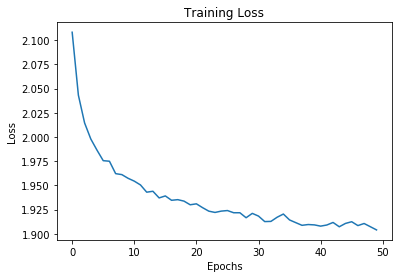

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = hist.history
loss_values = history_dict['loss']
#val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
#val_acc_values = history_dict['val_acc']
epochs = range(0, 50)

plt.figure()
plt.plot(epochs, loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

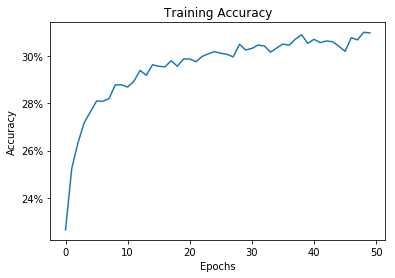

In [23]:
plt.figure()
plt.plot(epochs, acc_values)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.show()